<a href="https://colab.research.google.com/github/ekunomowunmi/sex-classification/blob/master/Fingerprint_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import cv2
import os
import pandas as pd

In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [5]:
#changing the working directory
%cd /content/

/content


# New Section

In [ ]:
pwd


'/content'

In [6]:
!mkdir Dataset
!cp /content/gdrive/MyDrive/Kaggle/archive.zip /content/Dataset/archive.zip
!unzip -q /content/Dataset/archive.zip -d /content/Dataset
!rm /content/Dataset/archive.zip


In [7]:
def extract_label(img_path, train=True):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    subject_id, etc = filename.split('__')

    if train:
        gender, lr, finger, _, _ = etc.split('_')
    else:
        gender, lr, finger, _ = etc.split('_')

    gender = 0 if gender == 'M' else 1
    lr =0 if lr == 'Left' else 1

    if finger == 'thumb':
        finger = 0
    elif finger == 'index':
        finger = 1
    elif finger == 'middle':
        finger = 2
    elif finger == 'ring':
        finger = 3
    elif finger == 'little':
        finger = 4


    return np.array([gender], dtype=np.uint16)

In [8]:
IMG_SIZE = 96

def load_data(path, train):
    print("loading data from: ", path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            label = extract_label(os.path.join(path, img),train)
            data.append([label[0], img_resize ])
        except Exception as e:
            pass
    return data

In [9]:
Real_path = "Dataset/socofing/SOCOFing/Real"
Easy_path = "Dataset/socofing/SOCOFing/Altered/Altered-Easy"
Medium_path = "Dataset/socofing/SOCOFing/Altered/Altered-Medium"
Hard_path   = "Dataset/socofing/SOCOFing/Altered/Altered-Hard"

easy_data = load_data(Easy_path, train = True)
medium_data = load_data(Medium_path, train = True)
hard_data = load_data(Hard_path, train = True)
test = load_data(Real_path, train = False)

data = np.concatenate([easy_data,medium_data,hard_data],axis=0)

loading data from:  Dataset/socofing/SOCOFing/Altered/Altered-Easy
loading data from:  Dataset/socofing/SOCOFing/Altered/Altered-Medium
loading data from:  Dataset/socofing/SOCOFing/Altered/Altered-Hard
loading data from:  Dataset/socofing/SOCOFing/Real


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
import random
random.shuffle(data)
random.shuffle(test)

In [11]:
data[0]

array([0, array([[160, 158, 158, ...,   0,   0,   0],
                 [160, 105, 121, ...,   0,   0,   0],
                 [160, 105, 255, ...,   0,   0,   0],
                 ...,
                 [  0,   0,   0, ...,   0,   0,   0],
                 [  0,   0,   0, ...,   0,   0,   0],
                 [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
      dtype=object)

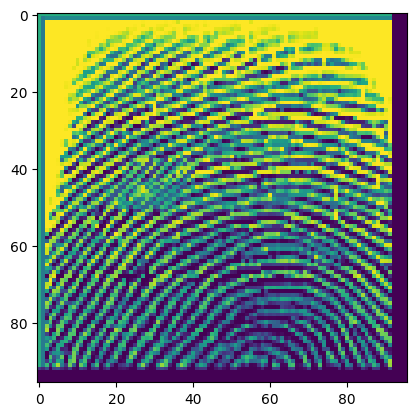

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(data[0][1])

In [13]:
X, y = [],[]

for label, feature in data:
    y.append(label)
    X.append(feature)


X_train = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_train = X_train/255

y_train = np.array(y)

In [14]:
X_train.shape

(49270, 96, 96, 1)

In [15]:
y_train.shape

(49270,)

In [16]:
np.unique(y_train)

array([0, 1], dtype=uint16)

In [17]:
y_train[:5]

array([0, 0, 0, 0, 1], dtype=uint16)

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Dropout, Flatten
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [19]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform',
           input_shape = [IMG_SIZE, IMG_SIZE, 1]),
    MaxPooling2D(2),
    Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(128, kernel_initializer='he_uniform', activation='relu'),
    Dense(1,activation='sigmoid'),

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [20]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train,y_train, batch_size=128, epochs=3, validation_split=0.2)

Epoch 1/3
308/308 [==============================] - 575s 2s/step - loss: 0.5636 - accuracy: 0.8022 - val_loss: 0.4093 - val_accuracy: 0.8146
Epoch 2/3
308/308 [==============================] - 569s 2s/step - loss: 0.3171 - accuracy: 0.8679 - val_loss: 0.2762 - val_accuracy: 0.8970
Epoch 3/3
308/308 [==============================] - 573s 2s/step - loss: 0.1569 - accuracy: 0.9452 - val_loss: 0.1487 - val_accuracy: 0.9493


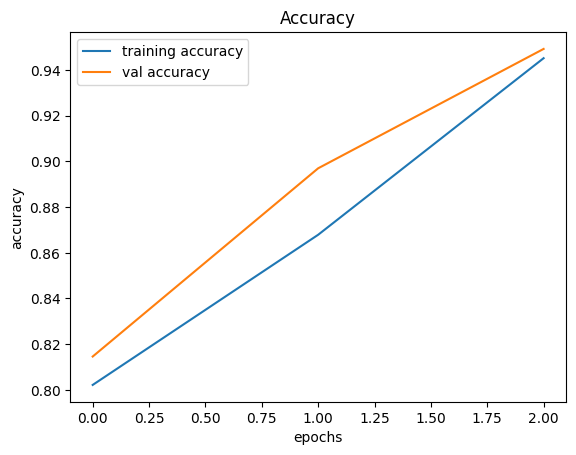

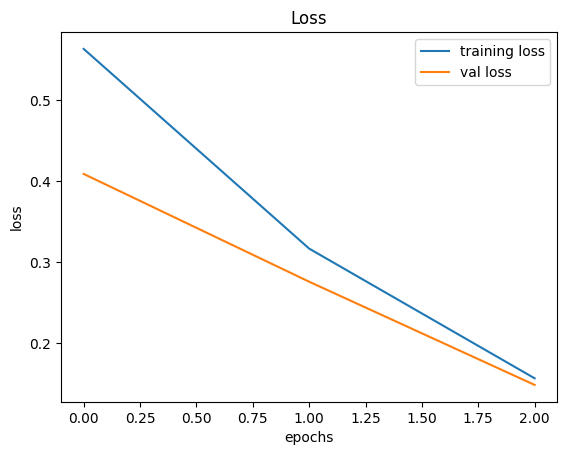

In [22]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title("Accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
X_test,y_test = [],[]

for label, feature in test:
    y_test.append(label)
    X_test.append(feature)

X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test = X_test/255

y_test = np.array(y_test)

In [24]:
X_test.shape

(6000, 96, 96, 1)

In [25]:
y_test.shape

(6000,)

In [26]:
model.evaluate(X_test,y_test)

188/188 [==============================] - 23s 121ms/step - loss: 0.1142 - accuracy: 0.9615


[0.11422310024499893, 0.9614999890327454]

In [33]:
!mkdir -p saved_model
model.save('saved_model/my_model')

mkdir: cannot create directory ‘saved_model’: File exists
